In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ombre as om
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
import numpy as np

In [3]:
import pyia

def get_gaia_sources(ras, decs, rads, magnitude_limit=18, epoch=2020, dr=2):
    """
    Will find gaia sources using a TAP query, accounting for proper motions.
    Inputs have be hashable, e.g. tuples
    Parameters
    ----------
    ras : tuple
        Tuple with right ascension coordinates to be queried
        shape nsources
    decs : tuple
        Tuple with declination coordinates to be queried
        shape nsources
    rads : tuple
        Tuple with radius query
        shape nsources
    magnitude_limit : int
        Limiting magnitued for query
    Returns
    -------
    Pandas DatFrame with number of result sources (rows) and Gaia columns
    """
    if not hasattr(ras, "__iter__"):
        ras = [ras]
    if not hasattr(decs, "__iter__"):
        decs = [decs]
    if not hasattr(rads, "__iter__"):
        rads = [rads]
    wheres = [
        f"""1=CONTAINS(
                  POINT('ICRS',{ra},{dec}),
                  CIRCLE('ICRS',ra,dec,{rad}))"""
        for ra, dec, rad in zip(ras, decs, rads)
    ]

    where = """\n\tOR """.join(wheres)
    if dr == 2:
        # CH: We don't need a lot of these columns we could greatly reduce it
        gd = pyia.GaiaData.from_query(
            f"""SELECT designation,
            coord1(prop) AS ra, coord2(prop) AS dec, parallax,
            parallax_error, pmra, pmdec,
            phot_g_mean_flux,
            phot_g_mean_mag,
            phot_bp_mean_mag,
            phot_rp_mean_mag FROM (
     SELECT *,
     EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, 0, ref_epoch, {epoch}) AS prop
     FROM gaiadr2.gaia_source
     WHERE {where}
    )  AS subquery
    WHERE phot_g_mean_mag<={magnitude_limit}
    """
        )
    elif dr == 3:
        gd = pyia.GaiaData.from_query(
            f"""SELECT designation,
            coord1(prop) AS ra, coord2(prop) AS dec, parallax,
            parallax_error, pmra, pmdec,
            phot_g_mean_flux,
            phot_g_mean_mag,
            phot_bp_mean_mag,
            phot_rp_mean_mag FROM (
             SELECT *,
             EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, 0, ref_epoch, {epoch}) AS prop
             FROM gaiaedr3.gaia_source
             WHERE {where}
            )  AS subquery
            WHERE phot_g_mean_mag<={magnitude_limit}
            """
        )
    else:
        raise ValueError("Please pass a valid data release")
    return gd.data.to_pandas()

In [175]:
paths = om.query.download_target('09030762+0757108')
hdu = fits.open(paths[0])

In [176]:
hdu[0].header['FILTER']

'G141'

In [194]:
wcs = WCS(hdu[1])
ras, decs = wcs.all_pix2world([[-100, 0], [hdu[1].header['NAXIS1'] - 100, hdu[1].header['NAXIS1']]], 0).T
ra, dec = np.mean(ras), np.mean(decs)
rad = np.max(np.hypot(ras - ra, decs - dec))
gd = get_gaia_sources(ra, dec, rad, epoch=int(hdu[0].header['DATE-OBS'][:4]), dr=3, magnitude_limit=20)

INFO: Query finished. [astroquery.utils.tap.core]


In [178]:
img = hdu[1].data
Y, X = np.mgrid[:img.shape[0], :img.shape[1]]

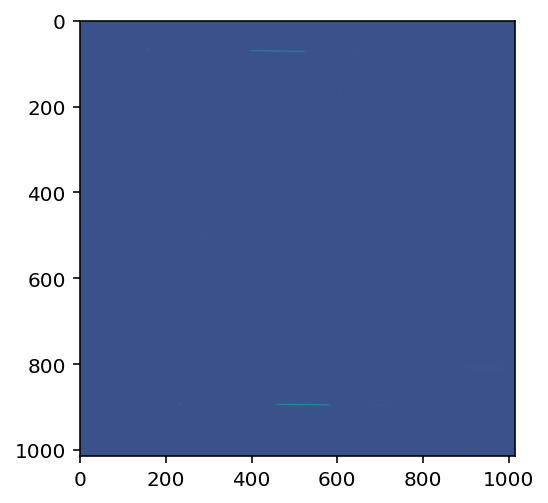

In [179]:
plt.imshow(img)

In [180]:
ras, decs = wcs.all_pix2world(np.vstack([X.ravel(), Y.ravel()]).T, 0).T
ras = ras.reshape(X.shape)
decs = decs.reshape(X.shape)

In [181]:
import astropy.units as u

<Figure size 432x288 with 0 Axes>

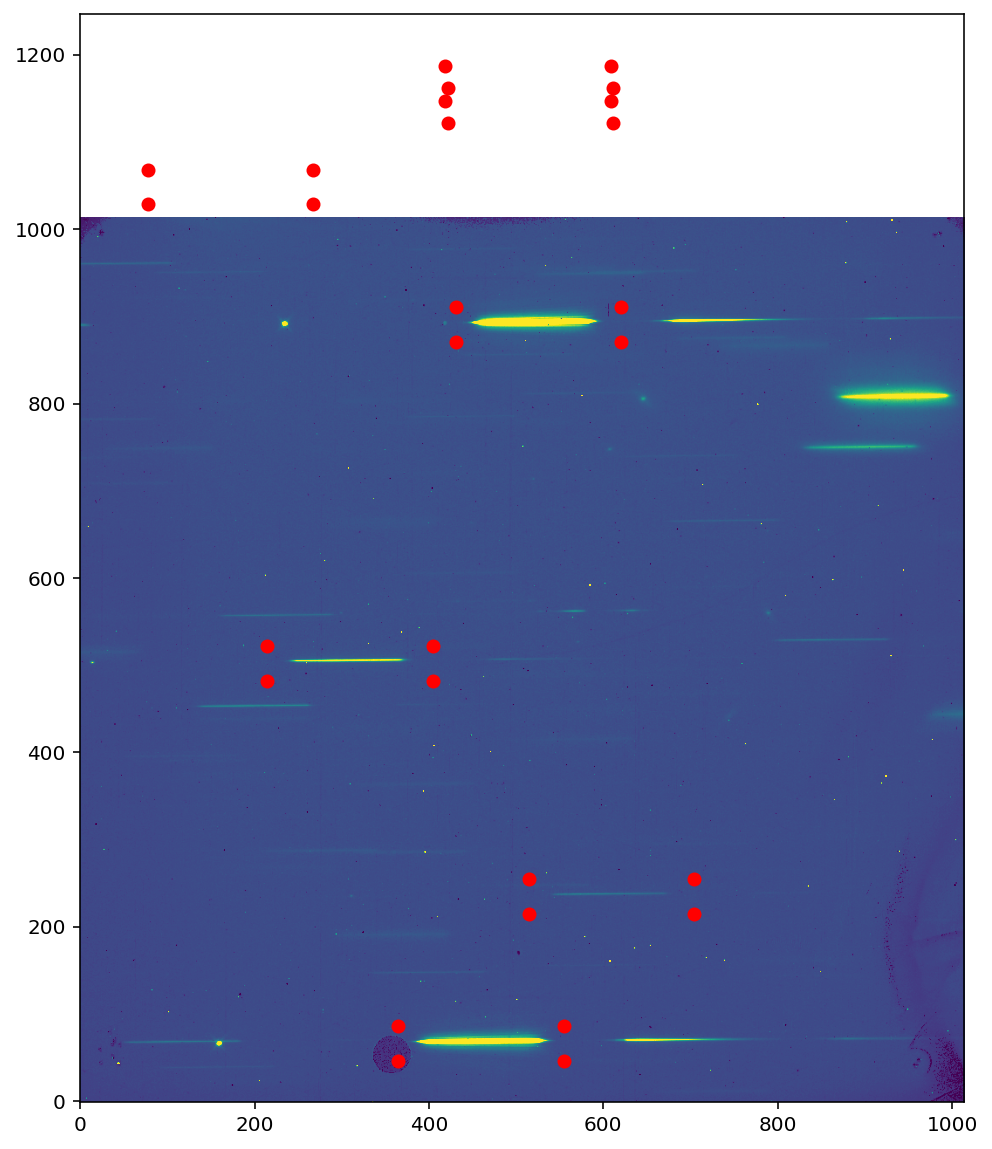

In [193]:
plt.figure()
#plt.pcolormesh(ras, decs, img)
plt.figure(figsize=(10, 10))
plt.gca().set_aspect("equal")
plt.imshow(img, origin='lower', vmin=0, vmax=10)
for idx, source in gd.iterrows():
    x0, y0 = wcs.all_world2pix([[source.ra, source.dec]], 0)[0]
    x1, x2 = x0 + 10, x0 + 200
    ys = y0, y0 - np.sign(hdu[0].header['POSTARG2']) * hdu[0].header['SCAN_LEN'] * 9.5
    y1 = np.min(ys) - 20
    y2 = np.max(ys) + 20
    plt.scatter(x1, y1, c='r')
    plt.scatter(x1, y2, c='r')
    plt.scatter(x2, y1, c='r')
    plt.scatter(x2, y2, c='r')


In [183]:
np.sign(hdu[0].header['POSTARG2']) * hdu[0].header['SCAN_LEN']

0.0

In [184]:
x1, y1 = wcs.all_pix2world([[source.ra + dx, source.dec + dy]], 0)[0]

145.1970062256

In [ ]:
import astropy.units as u

In [ ]:
(3.629925155640E+01*u.arcsec).to(u.deg)

In [ ]:
hdu[0].header

In [ ]:
plt.imshow(mask)

In [ ]:
plt.imshow(hdu[1].data, vmin=0, vmax=10)

In [ ]:
plt.imshow(hdu[1].data, vmin=0, vmax=10)
for idx, source in gd.iterrows():
    plt.scatter(*wcs.all_world2pix([[source.ra, source.dec]], 0)[0], c='r')